**In this file we will be evaluating SVC and KNN with HyperParameter Tuning to see which is a better fit**

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# loading the csv data to a Pandas DataFrame
file_path = 'heart_disease_data.csv'
heart_df = pd.read_csv(file_path)

In [10]:
# Splitting the Data into Depandant and Indepandant Variables
X = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]

In [11]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
models = {
    "Support Vector Classifier": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [13]:

# Define parameter grids for each model
param_grids = {
    "Support Vector Classifier": {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5,6, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}


In [14]:
# Initialize dictionaries and lists to store results
best_params = {}
best_models = {}
results = {}

# Initialize lists for evaluation metrics
accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

# Number of folds for cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Loop through each model and perform parameter tuning with GridSearchCV
for name, model in models.items():
    if name in param_grids:
        # Initialize GridSearchCV
        grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='accuracy', n_jobs=-1)

        # Perform grid search
        grid_search.fit(X_train_scaled, y_train)

        # Store best parameters and best model
        best_params[name] = grid_search.best_params_
        best_models[name] = grid_search.best_estimator_

        # Evaluate the model with best parameters
        y_pred = best_models[name].predict(X_test_scaled)
        y_prob = best_models[name].predict_proba(X_test_scaled)[:, 1]

        # Calculate and store metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_prob))

        # Store results for each model
        results[name] = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1 Score': np.mean(f1s),
            'AUC': np.mean(aucs)
        }

# Display the best parameters for each model
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")


Best parameters for Support Vector Classifier: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}


In [15]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1 Score,AUC
Support Vector Classifier,0.885246,0.878788,0.90625,0.892308,0.924569
K-Nearest Neighbors,0.868852,0.874878,0.87500,0.874725,0.927263


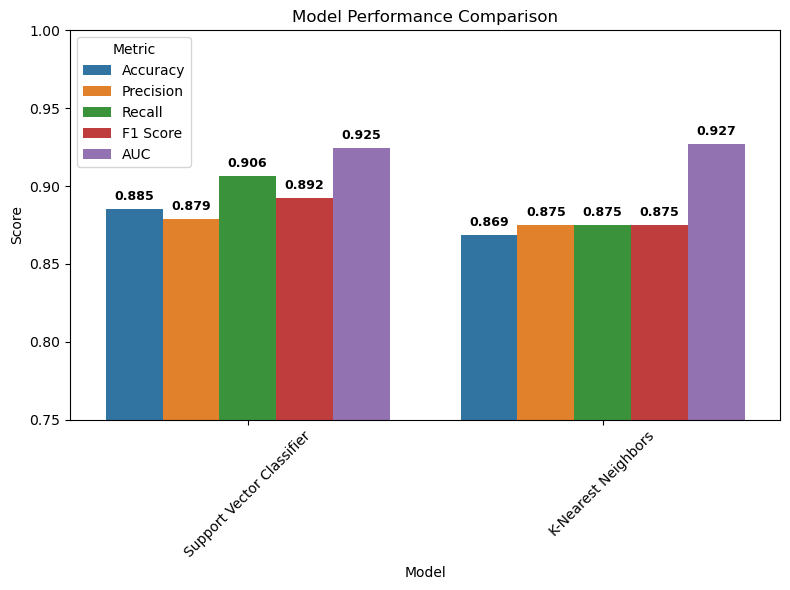

In [16]:
# Convert the results dictionary to a DataFrame and add a 'Model' column
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Melt the DataFrame to have a long-form DataFrame suitable for seaborn
results_df_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=results_df_melted, x='Model', y='Score', hue='Metric')

# Add the value labels above or within each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9),  # 9 points vertical offset
                textcoords = 'offset points',
                fontsize=9, 
                color='black', 
                weight='bold')

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Adjust y-axis limits to zoom in on differences
plt.ylim(0.75, 1)  # Example range; adjust based on your data

plt.tight_layout()
plt.show()


- So based on our above output we will finalize SVC as our final model of training and deployment with an **accuracy** of **88.5%** 

- In Heart_Disease_Project Notebook we will only have the SVC model trained with the best parameters as derived above 